In [1]:
#1kmeans

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
online = pd.read_excel('Online Retail.xlsx')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
online = online[online.CustomerID.notnull()]
online = online.sample(frac = .3).reset_index(drop = True)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579069,23542,WALL ART 70'S ALPHABET,2,2011-11-28 10:31:00,8.25,14911.0,EIRE
1,562129,82567,"AIRLINE LOUNGE,METAL SIGN",6,2011-08-03 09:09:00,2.10,13186.0,United Kingdom
2,567805,23330,DECORATIVE WICKER HEART MEDIUM,2,2011-09-22 12:15:00,1.25,12854.0,United Kingdom
3,566959,22999,TRAVEL CARD WALLET VINTAGE LEAF,2,2011-09-15 17:00:00,0.42,17530.0,United Kingdom
4,541848,90145,SILVER HOOP EARRINGS WITH FLOWER,2,2011-01-23 13:31:00,5.95,17611.0,United Kingdom


In [4]:
online['InvoiceDay'] = online.InvoiceDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay
0,579069,23542,WALL ART 70'S ALPHABET,2,2011-11-28 10:31:00,8.25,14911.0,EIRE,2011-11-28
1,562129,82567,"AIRLINE LOUNGE,METAL SIGN",6,2011-08-03 09:09:00,2.10,13186.0,United Kingdom,2011-08-03
2,567805,23330,DECORATIVE WICKER HEART MEDIUM,2,2011-09-22 12:15:00,1.25,12854.0,United Kingdom,2011-09-22
3,566959,22999,TRAVEL CARD WALLET VINTAGE LEAF,2,2011-09-15 17:00:00,0.42,17530.0,United Kingdom,2011-09-15
4,541848,90145,SILVER HOOP EARRINGS WITH FLOWER,2,2011-01-23 13:31:00,5.95,17611.0,United Kingdom,2011-01-23


In [5]:
print('Min : {}, Max : {}'.format(min(online.InvoiceDay), max(online.InvoiceDay)))

Min : 2010-12-01 00:00:00, Max : 2011-12-09 00:00:00


In [6]:
pin_date = max(online.InvoiceDay) + dt.timedelta(1)
online['TotalSum'] = online.Quantity * online.UnitPrice
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
0,579069,23542,WALL ART 70'S ALPHABET,2,2011-11-28 10:31:00,8.25,14911.0,EIRE,2011-11-28,16.50
1,562129,82567,"AIRLINE LOUNGE,METAL SIGN",6,2011-08-03 09:09:00,2.10,13186.0,United Kingdom,2011-08-03,12.60
2,567805,23330,DECORATIVE WICKER HEART MEDIUM,2,2011-09-22 12:15:00,1.25,12854.0,United Kingdom,2011-09-22,2.50
3,566959,22999,TRAVEL CARD WALLET VINTAGE LEAF,2,2011-09-15 17:00:00,0.42,17530.0,United Kingdom,2011-09-15,0.84
4,541848,90145,SILVER HOOP EARRINGS WITH FLOWER,2,2011-01-23 13:31:00,5.95,17611.0,United Kingdom,2011-01-23,11.90


In [7]:
rfm = online.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (pin_date - x.max()).days,
    'InvoiceNo' : 'count', 
    'TotalSum' : 'sum'})
rfm.rename(columns = {'InvoiceDate' : 'Recency',
                      'InvoiceNo' : 'Frequency', 
                      'TotalSum' : 'Monetary'}, inplace = True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,-77183.60
12347.0,2,51,935.61
12348.0,75,10,703.36
12349.0,18,19,372.72
12350.0,310,3,65.40


In [8]:
# create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 4, labels = r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(rfm.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(rfm.Monetary, q = 4, labels = m_labels)

rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values# sum up the three columns
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,325,1,-77183.60,1,1,1,111,3.0
12347.0,2,51,935.61,4,4,4,444,12.0
12348.0,75,10,703.36,2,2,4,224,8.0
12349.0,18,19,372.72,3,3,3,333,9.0
12350.0,310,3,65.40,1,1,1,111,3.0


In [9]:
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']
})
rfm_agg.round(1).head()

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         260.5       2.9   -156.8   410
4.0         169.6       4.4     54.3   378
5.0         143.0       6.9    108.5   464
6.0         103.7       9.1    175.9   484
7.0          84.5      13.2    246.9   413

In [10]:
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346.0,325,1,-77183.60,1,1,1,111,3.0,Green
12347.0,2,51,935.61,4,4,4,444,12.0,Gold
12348.0,75,10,703.36,2,2,4,224,8.0,Silver
12349.0,18,19,372.72,3,3,3,333,9.0,Silver
12350.0,310,3,65.40,1,1,1,111,3.0,Green


In [12]:

# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x# apply the function to Recency and MonetaryValue column 
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]# unskew the data
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.784,0.000,0.000
12347.0,0.693,3.932,6.841
12348.0,4.317,2.303,6.556
12349.0,2.890,2.944,5.921
12350.0,5.737,1.099,4.181
...,...,...,...
18278.0,4.290,1.099,4.122
18280.0,5.624,1.386,4.369
18282.0,1.946,1.386,3.915


In [13]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)

In [14]:
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)# Assign the clusters to datamart
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,1.00,1,1,1,111,3.0,Green,2
12347.0,2,51,935.61,4,4,4,444,12.0,Gold,0
12348.0,75,10,703.36,2,2,4,224,8.0,Silver,1
12349.0,18,19,372.72,3,3,3,333,9.0,Silver,1
12350.0,310,3,65.40,1,1,1,111,3.0,Green,2


In [15]:
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'RFM_Level', 'K_Cluster'], var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,CustomerID,RFM_Level,K_Cluster,Metrics,Value
0,12346.0,Green,2,Recency,1.374278
1,12347.0,Gold,0,Recency,-2.054048
2,12348.0,Silver,1,Recency,0.386387
3,12349.0,Silver,1,Recency,-0.574568
4,12350.0,Green,2,Recency,1.342628


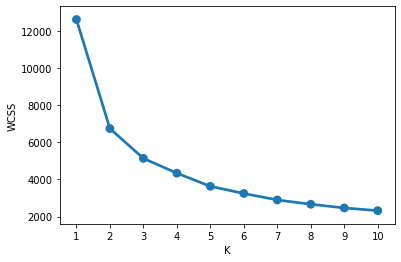

In [16]:
#best K in kmeans
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()